In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords
from multiprocessing import Pool
from tqdm import tqdm
from gensim.models import Word2Vec
import fasttext
import plotly.express as px
from nltk.probability import FreqDist
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [44]:
from catboost.utils import get_roc_curve, select_threshold

In [327]:
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV


In [307]:
df = pd.read_csv("wb_school_task_2.csv")

In [308]:
df['word_len'] = df.text.apply(lambda x: len(x.split()))
df['sym_len'] = df.text.apply(len)

In [309]:
df['sym_len'] = np.log(df['sym_len'])
df['word_len'] = np.log(df['word_len'])

In [310]:
np.seterr(divide = 'ignore') 
df['f1'] = np.log(df['f1'])
df['f2'] = np.log(df['f2'])
df['f4'] = np.log(df['f4'])
df['f5'] = np.log(df['f5'])
df['f7'] = np.log(df['f7'])
df['f8'] = np.log(df['f8'])

In [311]:
df['f1'] = df['f1'].fillna(df['f1'].mean())
df['f2'] = df['f2'].fillna(df['f2'].mean())
df['f4'] = df['f4'].fillna(df['f4'].mean())
df['f5'] = df['f5'].fillna(df['f5'].mean())
df['f7'] = df['f7'].fillna(df['f7'].mean())
df['f8'] = df['f8'].fillna(df['f8'].mean())

In [325]:
def get_metrics(y_true, y_pred) -> dict:
    
    metrics = {
        "recall_score": 0, 
        "precision_score": 0, 
        "f1_score" : 0
    }
    
    metrics["recall_score"] = recall_score(y_true, y_pred)
    metrics["precision_score"] = precision_score(y_true, y_pred)
    metrics["f1_score"] = f1_score(y_true, y_pred, average='micro')
    metrics["roc_auc_score"] = roc_auc_score(y_true, y_pred)
    
    return metrics

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(5,4))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [318]:
X = df[["f1","f2","f3", "f5","f7", "f8", "word_len"]]
y = df["label"]

In [319]:
X_train, X_test, y_train, y_test = tts(X, y, shuffle=True, stratify=y, train_size=0.7, random_state=123)

train_pool = Pool(
    X_train, y_train, 
)

validation_pool = Pool(
    X_test, y_test, 
)

In [362]:
model = CatBoostClassifier(use_best_model=True, 
                           iterations=20000,
                           learning_rate=0.001,
                           loss_function='Logloss').fit(train_pool, 
                                                    eval_set=validation_pool, 
                                                    verbose=1000)

0:	learn: 0.6928083	test: 0.6928366	best: 0.6928366 (0)	total: 1.97ms	remaining: 39.5s
1000:	learn: 0.5338666	test: 0.5512356	best: 0.5512356 (1000)	total: 1.76s	remaining: 33.3s
2000:	learn: 0.4909257	test: 0.5231772	best: 0.5231772 (2000)	total: 3.51s	remaining: 31.6s
3000:	learn: 0.4674659	test: 0.5129199	best: 0.5129199 (3000)	total: 5.31s	remaining: 30.1s
4000:	learn: 0.4508725	test: 0.5076713	best: 0.5076713 (4000)	total: 7.33s	remaining: 29.3s
5000:	learn: 0.4374271	test: 0.5050441	best: 0.5050441 (5000)	total: 9.13s	remaining: 27.4s
6000:	learn: 0.4255368	test: 0.5030598	best: 0.5030598 (6000)	total: 10.9s	remaining: 25.5s
7000:	learn: 0.4142718	test: 0.5014998	best: 0.5014945 (6998)	total: 12.8s	remaining: 23.8s
8000:	learn: 0.4023470	test: 0.5004385	best: 0.5004295 (7996)	total: 14.6s	remaining: 21.9s
9000:	learn: 0.3898465	test: 0.4992746	best: 0.4992684 (8999)	total: 16.5s	remaining: 20.1s
10000:	learn: 0.3775479	test: 0.4985970	best: 0.4985712 (9886)	total: 18.2s	remaining

In [363]:
roc_curve_values = get_roc_curve(model, train_pool)
boundary = select_threshold(model, curve=roc_curve_values)
model.set_probability_threshold(boundary)

In [364]:
pred = model.predict(validation_pool).flatten()
catboost_metrics = get_metrics(pred, y_test)
catboost_metrics

{'recall_score': 0.46417445482866043,
 'precision_score': 0.6008064516129032,
 'f1_score': 0.7107790821771612,
 'roc_auc_score': 0.6517300845571873}

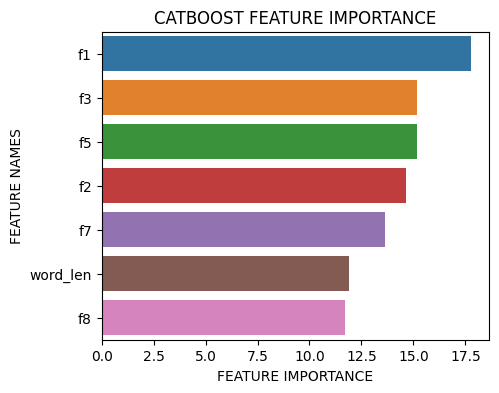

In [365]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST ')

In [369]:
model = CatBoostClassifier(iterations=20000,
                           learning_rate=0.001, 
                           verbose=1000)

In [370]:
used_metrics = ['f1_micro', 'precision', 'recall', 'roc_auc']

In [371]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=123)

In [375]:
crossval = cross_validate(model, X, y, cv=skf, scoring=used_metrics, return_estimator=True)

0:	learn: 0.6928288	total: 6.85ms	remaining: 2m 16s
1000:	learn: 0.5363490	total: 1.76s	remaining: 33.4s
2000:	learn: 0.4936243	total: 3.48s	remaining: 31.3s
3000:	learn: 0.4707700	total: 5.2s	remaining: 29.4s
4000:	learn: 0.4547399	total: 6.92s	remaining: 27.7s
5000:	learn: 0.4414746	total: 8.73s	remaining: 26.2s
6000:	learn: 0.4299142	total: 10.4s	remaining: 24.3s
7000:	learn: 0.4189833	total: 12.2s	remaining: 22.7s
8000:	learn: 0.4070716	total: 13.9s	remaining: 20.9s
9000:	learn: 0.3940825	total: 15.7s	remaining: 19.2s
10000:	learn: 0.3806750	total: 17.6s	remaining: 17.6s
11000:	learn: 0.3683469	total: 19.3s	remaining: 15.8s
12000:	learn: 0.3568962	total: 21.1s	remaining: 14.1s
13000:	learn: 0.3459658	total: 22.9s	remaining: 12.3s
14000:	learn: 0.3359174	total: 24.6s	remaining: 10.5s
15000:	learn: 0.3263636	total: 26.3s	remaining: 8.77s
16000:	learn: 0.3173158	total: 28s	remaining: 7s
17000:	learn: 0.3088830	total: 29.7s	remaining: 5.25s
18000:	learn: 0.3010730	total: 31.5s	remainin

In [389]:
crossval

{'fit_time': array([36.93963385, 36.56076813, 37.17944598, 38.05707502]),
 'score_time': array([0.02483201, 0.02138114, 0.02133298, 0.02774978]),
 'estimator': [<catboost.core.CatBoostClassifier at 0x12bc763b0>,
 'test_f1_micro': array([0.77080666, 0.78617157, 0.78745198, 0.77051282]),
 'test_precision': array([0.68      , 0.70967742, 0.67826087, 0.64516129]),
 'test_recall': array([0.24757282, 0.32038835, 0.37681159, 0.29126214]),
 'test_roc_auc': array([0.73051921, 0.7301984 , 0.76046559, 0.71810832])}

In [391]:
crossval["estimator"][2].save_model("model")